In [39]:
import wrf
from wrf import getvar, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim
import os
import matplotlib.pyplot as plt
from load_wrf import load_one_wrf, load_all_wrf
import numpy as np
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FixedLocator
from datetime import datetime

In [3]:
# Load the WRF data
wrf_dir = 'D:/Projects/fiji-training-2024/data/wrf'

rainc = load_all_wrf(wrf_dir, 'RAINC')
rainnc = load_all_wrf(wrf_dir, 'RAINNC')


In [4]:
# sum the RAINC and RAINNC variables
rain = rainc + rainnc

In [43]:
# get valid time
valid_time = rain[1].Time.values
valid_time = valid_time.astype('datetime64[s]').astype(datetime)
valid_time_str = valid_time.strftime('%Y-%m-%d %H:%M UTC')

In [16]:
# Get the lat/lon coordinates
lats, lons = latlon_coords(rain)
lons = np.where(lons < 0, lons + 360, lons) # convert the west longitude value to east

In [17]:
# calculate 1 hour rainfall accumulation
rr1 = rain[0]
rr2 = rain[1]
rr = rr2 - rr1
rr


<xarray.DataArray (south_north: 402, west_east: 369)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.38294844e-02, 2.12715063e-02, 1.17216855e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.38265593e-03, 1.04259467e-03, 6.04912341e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.24447071e-03, 8.78526538e-04, 5.72972149e-02],
       ...,
       [0.00000000e+00, 8.35326373e-30, 0.00000000e+00, ...,
        4.81604773e-04, 4.77815571e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.91389667e-35, ...,
        3.29334900e-04, 4.07139887e-04, 0.00000000e+00],
       [1.05053245e-03, 6.73982084e-01, 5.58898807e-01, ...,
        1.64278448e-01, 1.59199238e-01, 1.78991875e-04]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 173.9 174.0 ... -175.9 -175.9
    XLAT     (south_north, west_east) float32 -22.32 -22.32 ... -11.75 -11.75
Dimensions without coordinates: south_north, west_east

In [26]:
colorlist = ["#FFFFFF","#DCDCFF","#BEBEFF","#9696FF","#6464F0","#4646C8","#282896","#007800","#00A000","#00D200","#00F000","#FFFF00","#FFE700","#FFCF00","#FFB700","#FF9E00","#FF8600","#FF6E00","#F35C00","#E64900","#DA3700","#CD2500","#C11200","#960000","#5A0000","#280000"]
# levels = [0.5, 1, 3, 5, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 110, 120, 140]
levels = [0.01, 0.1, 0.3, 1, 3, 5, 7, 10, 14, 17, 20, 50]

# Create a custom colormap and normalization
cmap = mcolors.LinearSegmentedColormap.from_list("", colorlist)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
cmap.set_over(colorlist[-1])
cmap.set_under(colorlist[0])

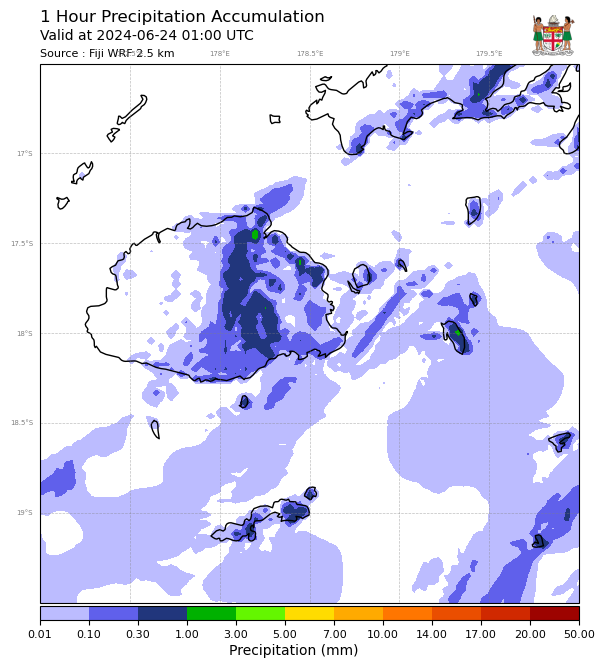

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

rain_contour = ax.contourf(lons, lats, rr, levels=levels, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

# zoom in a bit to Viti Levu
ax.set_extent([177, 180, -19.5, -16.5], crs=ccrs.PlateCarree())

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# add colorbar
pos = ax.get_position() # get the original position
cbaxes = fig.add_axes([pos.x0, pos.y0 - 0.025, pos.x1 - pos.x0, 0.02])  # colorbar axes position left,bottom,width,height
plt.colorbar(rain_contour, cax=cbaxes, orientation='horizontal', ticks=levels, extend="both", cmap=cmap)
cbaxes.tick_params(labelsize=8)

# add colorbar text
cbar_text = 'Precipitation (mm)'
cbpos = cbaxes.get_position()
ax.text(x=0.5, y=cbpos.y0 - 0.05, s=cbar_text, size=10, ha="center", transform=fig.transFigure)

# Add title and time text
title_text = '1 Hour Precipitation Accumulation'
time_text = f'Valid at {valid_time_str}'
model_text = 'Source : Fiji WRF 2.5 km'

ax.set_title(title_text, x=pos.x0, y=pos.y1 + 0.06, pad=25, fontsize=12,ha="left", transform=fig.transFigure)
ax.text(x=pos.x0, y=pos.y1 + 0.035, s=time_text,transform=fig.transFigure, size=10, ha="left")
ax.text(x=pos.x0, y=pos.y1 + 0.01, s = model_text, transform=fig.transFigure, size=8, ha="left")

# Add logo
lgaxes = fig.add_axes([pos.x1 - 0.05, pos.y1 + 0.01, 0.06, 0.06], )  # l,b,w,h
lgaxes.imshow(plt.imread("D:/Projects/fiji-training-2024/data/Coat_of_arms_of_Fiji.png"))
lgaxes.axis("off")

# Draw gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.bottom_labels = False
gl.top_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'gray'}
gl.ylabel_style = {'size': 5, 'color': 'gray'}

# Set specific values for the gridlines
# gl.xlocator = FixedLocator([165, 170, 175, 180, -175, -170, -165, -160, -155])
# gl.ylocator = FixedLocator([-35, -30, -25, -20, -15, -12.5, -10, -7.5, -5])

